In [1]:
import fastf1 as ff1
import pandas as pd
import sys
import os
sys.path.append(os.path.dirname("/home/ben/Individual_Project/DB"))
from DB.models import Circuit, RacingWeekend, Driver, Session, SessionResult, init_db
from database_operations import DatabaseOperations
from race_data import RaceDataSetup
from overtake_model import OvertakingModel

from race_dataframe import RaceDataframe
from race_sim import RaceSimulator
from evaluation import RaceSimEvaluation
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 

In [2]:
db = DatabaseOperations(2024, "Sakhir")
race_dataframe = RaceDataframe(db)
race_setup = RaceDataSetup(db, race_dataframe)
overtake = OvertakingModel(race_dataframe.race_df)


In [3]:
df = race_dataframe.race_df

max_laps_per_driver = df.groupby('driver_number')['lap_num'].max()
max_lap_all_drivers = max_laps_per_driver.min()
actual_df = df[(df["lap_num"]==max_lap_all_drivers) & (df["sector"]==3)]
# actual_df = df[(df["lap_num"]==max_lap_all_drivers) ]

print(max_lap_all_drivers)
race_setup.max_laps = max_lap_all_drivers
simulation = RaceSimulator(race_setup, overtake)
simulation.simulate()
sim_df = simulation.get_results_as_dataframe()


55


In [4]:
# df[df["driver_number"]==1]

In [5]:
actual_df = actual_df.sort_values(by='cumulative_time').reset_index(drop=True)
sim_df = sim_df.sort_values(by='cumulative_time').reset_index(drop=True)

# For actual_df
first_place_actual_time = actual_df['cumulative_time'].iloc[0]  # Cumulative time of the driver in 1st place
actual_df['gap_to_first_place'] = actual_df['cumulative_time'] - first_place_actual_time

# For sim_df
first_place_simulated_time = sim_df['cumulative_time'].iloc[0]  # Cumulative time of the driver in 1st place
sim_df['gap_to_first_place'] = sim_df['cumulative_time'] - first_place_simulated_time

merged_df = pd.merge(
    actual_df[['driver_number', 'cumulative_time', 'gap_to_first_place']],  # Include 'gap_to_first_place' from actual_df
    sim_df[['driver_number', 'cumulative_time', 'gap_to_first_place']],     # Include 'gap_to_first_place' from sim_df
    on='driver_number',
    how='inner',  # Ensure only matching drivers are included
    suffixes=('_actual', '_simulated')  # Use suffixes to differentiate cumulative times
)


merged_df['error_in_gaps_to_first'] = (merged_df['gap_to_first_place_simulated'] - merged_df['gap_to_first_place_actual'])

merged_df['error_in_cumulative_time'] = (merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated'])

merged_df['abs_error_in_gaps_to_first'] = (merged_df['gap_to_first_place_simulated'] - merged_df['gap_to_first_place_actual']).abs()

merged_df['abs_error_in_cumulative_time'] = (merged_df['cumulative_time_actual'] - merged_df['cumulative_time_simulated']).abs()

In [6]:
import pandas as pd
from scipy.stats import wilcoxon, spearmanr

# Wilcoxon Signed-Rank Test for cumulative times
wilcoxon_cumulative = wilcoxon(merged_df['error_in_cumulative_time'])

# Wilcoxon Signed-Rank Test for gaps to first place
wilcoxon_gaps = wilcoxon(merged_df['error_in_gaps_to_first'])

# Spearman Correlation for cumulative times
spearman_corr_cumulative = spearmanr(
    merged_df['cumulative_time_actual'], 
    merged_df['cumulative_time_simulated']
)

# Spearman Correlation for gaps to first place
spearman_corr_gaps = spearmanr(
    merged_df['gap_to_first_place_actual'], 
    merged_df['gap_to_first_place_simulated']
)

# Mean Absolute Error (MAE) for cumulative times
mae_cumulative = merged_df['abs_error_in_cumulative_time'].mean()

# Mean Absolute Error (MAE) for gaps to first place
mae_gaps = merged_df['abs_error_in_gaps_to_first'].mean()

# Create a dictionary to store the results
metrics_data = {
    "Metric": [
        "Wilcoxon Statistic",
        "Wilcoxon p-value",
        "Spearman Correlation Coefficient",
        "Spearman p-value",
        "Mean Absolute Error (MAE)"
    ],
    "Cumulative Times": [
        wilcoxon_cumulative.statistic,
        wilcoxon_cumulative.pvalue,
        spearman_corr_cumulative.correlation,
        spearman_corr_cumulative.pvalue,
        mae_cumulative
    ],
    "Gaps to First Place": [
        wilcoxon_gaps.statistic,
        wilcoxon_gaps.pvalue,
        spearman_corr_gaps.correlation,
        spearman_corr_gaps.pvalue,
        mae_gaps
    ]
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Round the values in the DataFrame to 3 decimal places
metrics_df = metrics_df.round(5)

# Display the rounded DataFrame
metrics_df

,Metric,Cumulative Times,Gaps to First Place
0,Wilcoxon Statistic,0.00000,66.00000
1,Wilcoxon p-value,0.00000,0.24320
2,Spearman Correlation Coefficient,0.86617,0.86617
3,Spearman p-value,0.00000,0.00000
4,Mean Absolute Error (MAE),173.44587,12.69274


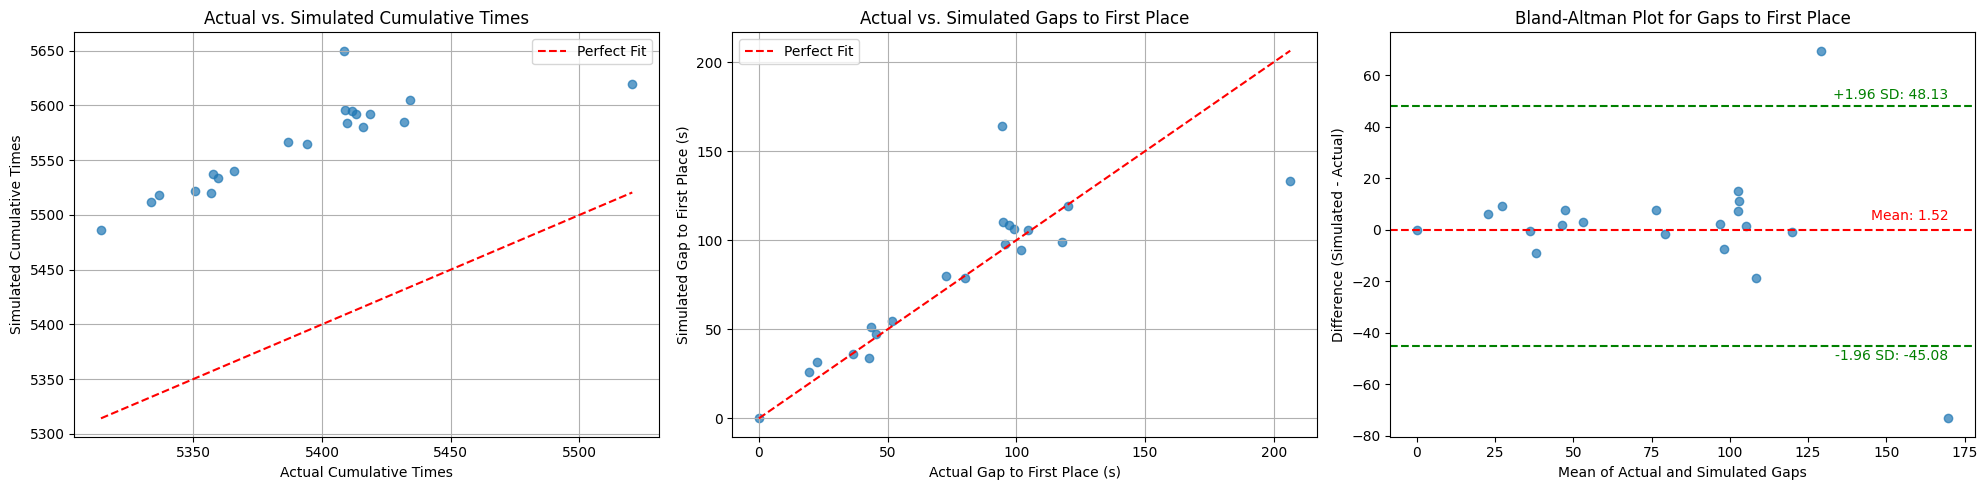

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(20, 5))


axes[0].scatter(merged_df['cumulative_time_actual'], merged_df['cumulative_time_simulated'], alpha=0.7)
axes[0].set_xlabel('Actual Cumulative Times')
axes[0].set_ylabel('Simulated Cumulative Times')
axes[0].set_title('Actual vs. Simulated Cumulative Times')
axes[0].plot([min(merged_df['cumulative_time_actual']), max(merged_df['cumulative_time_actual'])],
             [min(merged_df['cumulative_time_actual']), max(merged_df['cumulative_time_actual'])],
             color='red', linestyle='--', label='Perfect Fit')
axes[0].legend()
axes[0].grid(True)



axes[1].scatter(merged_df['gap_to_first_place_actual'], merged_df['gap_to_first_place_simulated'], alpha=0.7)
axes[1].plot([merged_df['gap_to_first_place_actual'].min(), merged_df['gap_to_first_place_actual'].max()],
             [merged_df['gap_to_first_place_actual'].min(), merged_df['gap_to_first_place_actual'].max()],
             color='red', linestyle='--', label='Perfect Fit')
axes[1].set_xlabel("Actual Gap to First Place (s)")
axes[1].set_ylabel("Simulated Gap to First Place (s)")
axes[1].set_title("Actual vs. Simulated Gaps to First Place")
axes[1].legend()
axes[1].grid(True)



mean_values = (merged_df['gap_to_first_place_actual'] + merged_df['gap_to_first_place_simulated']) / 2
differences = merged_df['gap_to_first_place_simulated'] - merged_df['gap_to_first_place_actual']

# Calculate mean difference and limits of agreement
mean_difference = np.mean(differences)
std_difference = np.std(differences)
upper_limit = mean_difference + 1.96 * std_difference
lower_limit = mean_difference - 1.96 * std_difference

# Scatter plot
axes[2].scatter(mean_values, differences, alpha=0.7)
axes[2].axhline(y=0, color='r', linestyle='--')  # Add a reference line at zero
axes[2].axhline(y=upper_limit, color='g', linestyle='--')  # Upper limit
axes[2].axhline(y=lower_limit, color='g', linestyle='--')  # Lower limit

axes[2].text(
    max(mean_values), mean_difference+4,
    f'Mean: {mean_difference:.2f}', color='red', va='center', ha='right'
)
axes[2].text(
    max(mean_values), upper_limit+4,
    f'+1.96 SD: {upper_limit:.2f}', color='green', va='center', ha='right'
)
axes[2].text(
    max(mean_values), lower_limit-4,
    f'-1.96 SD: {lower_limit:.2f}', color='green', va='center', ha='right'
)

axes[2].set_xlabel('Mean of Actual and Simulated Gaps')
axes[2].set_ylabel('Difference (Simulated - Actual)')
axes[2].set_title('Bland-Altman Plot for Gaps to First Place')



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()